# Section 6 - Neural bigrams

In this section, instead of using the couting method, we will be using a neuron to model p(w|wt-1).

- a neuron, in this insance, is a logistic regression

### How do we represent words?
- Recall: logistic regression only works on numbers
- logit = w.T * x (this is simply the transposed weights times the inputs)
- Recall that we are given an input vector x and output vector y:
    - if x= last work, y = current word, this this is exactly a bigram!!!
- p(y|x) = softmax(w.T * x)
- So for our logistic model:
    - X  is an N x D matrix 
    - Y is an N X K
    - N is num observations
    - D is number of input features
    - K is number of output class
    - **In this case, D = K = V (vocab size) because our input is a one-hot encoded LAST word, and output is onehot encoded CURRENT word**
    - Create X & Y by looping over corpus and storing every bigram encountered
    
### How do we find W (weights)?
- Gradient descent of course!
    - Loop through trainin data a bunch of times
    - Each time we move W (the weights) in the direction of the gradient
    - The gradient of the cost function with respect to the weights
    - Cost function is categorical cross-entropy, which is what you use for classification
    - **Note that the weights matrix is V * V as well, as we have to produce a probabilitiy for EACH word (if it was only a normal y vector, we would only get a single output!)**

![](pictures/nlp_6_crossent.jpg)

### Exercise
- Train another bigram model
- However, instead of using counts to caclulate probabilities, you are going to use a logistic regression to calculate the probabilities. 
- Visualize the training cost as a function of iteration
- **Not that the weight matrix W is the related to the bigram probabilitiy matrix!!!!**
    - If we take the softmax of W, we should get back an approximation of the bigram probability matrix
    - That said, we can also do the opposite: take the log(bigrams_probs) to get the W matrix
    - **SOFTMAX IS THE OPPOSITE OF LOG?!?**

#### So log(bigram_probs) is actually the IDEAL version of W, which logistic regression is trying to find

# Lets write some code!

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
from datetime import datetime
import os
import sys
from nltk.corpus import brown
import nltk
import operator

## 1. Create functions from rnn class

These are functions we have created in previous sessions:
- get sentences
- get sentences with word2idx
- get sentences with limited vocab
- get bigram probs

In [3]:
#GET SENTENCES FROM BROWN CORPUS
def get_sentences():
    # returns 57340 of the Brown corpus
    # each sentence is represented as a list of individual string tokens
    return brown.sents()
test = get_sentences()

#SENTANCES TO INDEX REPRESENTATION
def get_sentences_with_word2idx(print_v=False):
    #initialize sentences and index
    sentences = get_sentences()
    indexed_sentences = []
    i = 2
    #initialize start/end tags
    #capitalized so wont get confused with actual words in corpus
    word2idx = {'START': 0, 'END': 1}
    
    #loop through all sentances, add unique words to index
    for sentence in sentences:
        indexed_sentence = []
        for token in sentence:
            token = token.lower()
            if token not in word2idx:
                word2idx[token] = i
                i += 1
            #convert each sentance to index map
            indexed_sentence.append(word2idx[token])
        indexed_sentences.append(indexed_sentence)

    if print_v:
        print("Vocab size:", i)
    return indexed_sentences, word2idx

#SENTANCES TO INDEX REPRESENTATION WITH LIMITED VOCAB
KEEP_WORDS = set([
  'king', 'man', 'queen', 'woman',
  'italy', 'rome', 'france', 'paris',
  'london', 'britain', 'england',
])

def get_sentences_with_word2idx_limit_vocab(n_vocab=2000, keep_words=KEEP_WORDS, print_v=False):
    #initialize sentences and index
    sentences = get_sentences()
    indexed_sentences = []
    i = 2
    #initialize start/end tags
    #capitalized so wont get confused with actual words in corpus
    word2idx = {'START': 0, 'END': 1}
    idx2word = ['START', 'END']
    
    #Set start tokens to inf so they dont get removed when sorting by count
    word_idx_count = {
    0: float('inf'),
    1: float('inf'),
    }
    
    #Count each word 
    for sentence in sentences:
        indexed_sentence = []
        for token in sentence:
            token = token.lower()
            if token not in word2idx:
                idx2word.append(token)
                word2idx[token] = i
                i += 1
            # keep track of counts for later sorting
            idx = word2idx[token]
            word_idx_count[idx] = word_idx_count.get(idx, 0) + 1

            indexed_sentence.append(idx)
        indexed_sentences.append(indexed_sentence)

    # restrict vocab size
    # set all the words I want to keep to infinity
    # so that they are included when I pick the most
    for word in keep_words:
        word_idx_count[word2idx[word]] = float('inf')
    #tell sorted funciton to use 2nd item to sort
    sorted_word_idx_count = sorted(word_idx_count.items(), key=operator.itemgetter(1), reverse=True)
    word2idx_small = {}
    new_idx = 0
    #create new dictionary from old dict
    idx_new_idx_map = {}
    for idx, count in sorted_word_idx_count[:n_vocab]:
        word = idx2word[idx]
        if print_v:
            print(word, count)
        word2idx_small[word] = new_idx
        idx_new_idx_map[idx] = new_idx
        new_idx += 1
    # let 'unknown' be the last token
    # replcae all infrequent words are replaced with 'UNKOWN"
    word2idx_small['UNKNOWN'] = new_idx 
    unknown = new_idx
    
    # sanit check to make sure all words wanted to keep are still there
    assert('START' in word2idx_small)
    assert('END' in word2idx_small)
    for word in keep_words:
        assert(word in word2idx_small)

    # map old idx to new idx
    sentences_small = []
    for sentence in indexed_sentences:
        if len(sentence) > 1:
            new_sentence = [idx_new_idx_map[idx] if idx in idx_new_idx_map else unknown for idx in sentence]
            sentences_small.append(new_sentence)

    return sentences_small, word2idx_small

def get_bigrams_probs(sentences, V, start_idx, end_idx, smoothing=1):
    # initialize bigram_probs with size vocab * vocab
    # set all values as 1s and multiple mby smoothing (this will ensure minimum values is 1*smoothing value)
    bigram_probs = np.ones((V, V)) * smoothing
    for sentence in sentences:
        for i in range(len(sentence)):
            # begining word... add 1 to col row[0] (previous word) and col[i] (current word)
            # we loop through sentence items because they are in indexed format, so we can use values as indeces
            if i==0:
                bigram_probs[start_idx, sentence[i]] += 1
            else: #middle word
                bigram_probs[sentence[i-1], sentence[i]] += 1
            # if we're at the final word
            # we update the bigram for last -> current, AND current -> END token
            if i == len(sentence) - 1: # END word
                bigram_probs[sentence[i], end_idx] += 1
    # normalize the counts along the rows to get probabilities
    bigram_probs /= bigram_probs.sum(axis=1, keepdims=True)
    return bigram_probs

# 3. Define 'softmax' function
Remember, SOFTMAX turns an array into probabilities!

![](pictures/nlp_6_softmax.svg)

In [4]:
def softmax(a):
    a = a - a.max()
    exp_a = np.exp(a)
    return exp_a / exp_a.sum(axis=1, keepdims=True)

softmax(np.array([[0,2,3,4,5]]))

array([[ 0.00431992,  0.03192011,  0.08676786,  0.2358595 ,  0.6411326 ]])

# 4. Define 'smoothed_loss' function

This function just smoothes loss values to decrease variability.
Exponential smoothing is one of many window functions commonly applied to smooth data in signal processing, acting as low-pass filters to remove high frequency noise. 

The raw data sequence is often represented by $\{x_{t}\}$ beginning at time $t=0$, and the output of the exponential smoothing algorithm is commonly written as $\{s_{t}\}$, which may be regarded as a best estimate of what the next value of $x$ will be. When the sequence of observations begins at time $t=0$, the simplest form of exponential smoothing is given by the formulas:

![](pictures/nlp_6_exodecay.svg)

https://en.wikipedia.org/wiki/Exponential_smoothing

In [5]:
def smoothed_loss(x, decay=0.99):
    y = np.zeros(len(x))
    last = 0
    for t in range(len(x)):
        z = decay * last + (1-decay) * x[t]
        y[t] = z / (1 - decay ** (t+1))
        last = z
    return y
smoothed_loss([1,2,3,4,15])

array([ 1.        ,  1.50251256,  2.00670011,  2.51256256,  5.06050179])

# 5. Extract data

Using 'get_setences_with_word2idx_limit_vocab' from previous exercise.

In [6]:
#import data
sentences, word2idx = get_sentences_with_word2idx_limit_vocab(5000)

In [7]:
#extract dimensions
V = len(word2idx)
start_idx = word2idx['START']
end_idx = word2idx['END']
bigram_probs = get_bigrams_probs(sentences, V, start_idx, end_idx, smoothing=0.1)
print('Vocab length: ', V)
print('Start index: ', start_idx)
print('End index: ', end_idx)
bigram_probs[0:5].shape


Vocab length:  5001
Start index:  0
End index:  1


(5, 5001)

# 6. Run the model
A few points:
- When you run model, input should be shape (len(sentence)-1, V). This is because the last word (end_idx) will have no output, as it has no 'next word'. 
- When you run the model, you will train in batches, with each batch being a single sentence.
- **INPUT**: Each input batch (sentence) will be converted to a binary matrix, with the shape (len(sentence)-1, vocab). 
    - Convert each word in a sentence to a (1,V) vector
- **OUTPUT**: Do the same thing as the input vector, but when you add the binary values (to represent a single word in the V vector), you start at the SECOND word in the sentence. This represents the 'current' word (as opposed to the previous word)

In [8]:
import pandas as pd
### EXAMPLE OF INPUT/OUTPUT TRANSFORMATION
ex_sent = [1,5,6,2,1,3]
num_words = len(ex_sent)
vocab = 10

#initialize inputs and outputs
inputs = np.zeros((num_words-1,vocab))
targets = np.zeros((num_words-1, vocab))

### Each row represents a word in the sentance
### INPUTS: represents previous word
### TARGET: represents current word
inputs[np.arange(num_words-1),ex_sent[:num_words-1]]=1 #select first to second last word, make equal to 1
targets[np.arange(num_words-1),ex_sent[1:]]=1 #select second to last words, make equal to 1

### VISUALIZE
index=['SentWord '+str(x) for x in range(num_words-1)]
print("INPUT FROM SINGLE SENTENCE")
pd.DataFrame(inputs, columns=range(0,10), index=index[:]).style.highlight_max(axis=1)

INPUT FROM SINGLE SENTENCE


,0,1,2,3,4,5,6,7,8,9
SentWord 0,0,1,0,0,0,0,0,0,0,0
SentWord 1,0,0,0,0,0,1,0,0,0,0
SentWord 2,0,0,0,0,0,0,1,0,0,0
SentWord 3,0,0,1,0,0,0,0,0,0,0
SentWord 4,0,1,0,0,0,0,0,0,0,0


In [9]:
input_ = (5, 1000)
W_ = (1000,1000)
O_ = (5, 1000)

In [12]:
len(sentences)

57013

In [11]:
sentences[0]

[13,
 5000,
 661,
 2299,
 1639,
 74,
 1850,
 47,
 2180,
 16,
 5000,
 561,
 1129,
 1408,
 1202,
 26,
 71,
 483,
 27,
 21,
 97,
 5000,
 224,
 182,
 15]

In [138]:
#try using bigrams as the weights
#log(bigram_probs) should be close to optimized weights from logistic mod
#bigram losses should ALWAYS be the same (just a striaght line!)
#as we are not changing the weights at all...
W_bigram = np.log(bigram_probs)
bigram_losses = []

#initialize random weights for logistic model
W = np.random.randn(V, V) / np.sqrt(V)
losses = []
epochs = 1

#set learning rate t0 0.1
lr = 1e-1

t0 = datetime.now() #time model run

for epoch in range(epochs):
    # shuffle sentences at each epoch
    random.shuffle(sentences)
    
    j=0
    for sentence in sentences:
        #append start and end indx to sentence
        sentence = [start_idx] + sentence + [end_idx]
        n = len(sentence) #get sentence length
        #initialize inputs and outputs (each word represented by a single row in the V column binary vector)
        inputs = np.zeros((n-1, V))
        targets = np.zeros((n-1, V))
        inputs[np.arange(n-1), sentence[:n-1]]=1 #set 'previous words' to 1
        targets[np.arange(n-1), sentence[1:]] = 1 #set 'current words' to 1
        
        #predct by getting dot product of inputs and weights
        predictions = softmax(inputs.dot(W))
        
        #run a gradient descent step (check to make sure it matches function!!!)
        W = W - (lr * inputs.T.dot(predictions-targets))
        
        #keep track of loss values
        #CROSS ENTROPY WOOOOTTTT!!!!
        loss = -np.sum(targets * np.log(predictions)) / (n-1)
        losses.append(loss)
        
        #keep track of the bigram loss
        #only do it for the first epoch to avoid redundancy
        if epoch == 0:
            bigram_predictions = softmax(inputs.dot(W_bigram))
            bigram_loss = -np.sum(targets * np.log(bigram_predictions)) / (n-1)
            bigram_losses.append(bigram_loss)
        
        if j % 100 == 0:
            print("epoch:", epoch, "sentence: {}/{}".format(j, len(sentences),"loss:",loss))
        j+=1
print('Elapsed training time:', datetime.now() - t0)       

epoch: 0 sentence: 0/57013
epoch: 0 sentence: 100/57013
epoch: 0 sentence: 200/57013
epoch: 0 sentence: 300/57013
epoch: 0 sentence: 400/57013
epoch: 0 sentence: 500/57013
epoch: 0 sentence: 600/57013
epoch: 0 sentence: 700/57013
epoch: 0 sentence: 800/57013
epoch: 0 sentence: 900/57013
epoch: 0 sentence: 1000/57013
epoch: 0 sentence: 1100/57013
epoch: 0 sentence: 1200/57013
epoch: 0 sentence: 1300/57013
epoch: 0 sentence: 1400/57013
epoch: 0 sentence: 1500/57013
epoch: 0 sentence: 1600/57013
epoch: 0 sentence: 1700/57013
epoch: 0 sentence: 1800/57013
epoch: 0 sentence: 1900/57013
epoch: 0 sentence: 2000/57013
epoch: 0 sentence: 2100/57013
epoch: 0 sentence: 2200/57013
epoch: 0 sentence: 2300/57013
epoch: 0 sentence: 2400/57013
epoch: 0 sentence: 2500/57013
epoch: 0 sentence: 2600/57013
epoch: 0 sentence: 2700/57013
epoch: 0 sentence: 2800/57013
epoch: 0 sentence: 2900/57013
epoch: 0 sentence: 3000/57013
epoch: 0 sentence: 3100/57013
epoch: 0 sentence: 3200/57013
epoch: 0 sentence: 330

epoch: 0 sentence: 26800/57013
epoch: 0 sentence: 26900/57013
epoch: 0 sentence: 27000/57013
epoch: 0 sentence: 27100/57013
epoch: 0 sentence: 27200/57013
epoch: 0 sentence: 27300/57013
epoch: 0 sentence: 27400/57013
epoch: 0 sentence: 27500/57013
epoch: 0 sentence: 27600/57013
epoch: 0 sentence: 27700/57013
epoch: 0 sentence: 27800/57013
epoch: 0 sentence: 27900/57013
epoch: 0 sentence: 28000/57013
epoch: 0 sentence: 28100/57013
epoch: 0 sentence: 28200/57013
epoch: 0 sentence: 28300/57013
epoch: 0 sentence: 28400/57013
epoch: 0 sentence: 28500/57013
epoch: 0 sentence: 28600/57013
epoch: 0 sentence: 28700/57013
epoch: 0 sentence: 28800/57013
epoch: 0 sentence: 28900/57013
epoch: 0 sentence: 29000/57013
epoch: 0 sentence: 29100/57013
epoch: 0 sentence: 29200/57013
epoch: 0 sentence: 29300/57013
epoch: 0 sentence: 29400/57013
epoch: 0 sentence: 29500/57013
epoch: 0 sentence: 29600/57013
epoch: 0 sentence: 29700/57013
epoch: 0 sentence: 29800/57013
epoch: 0 sentence: 29900/57013
epoch: 0

epoch: 0 sentence: 53300/57013
epoch: 0 sentence: 53400/57013
epoch: 0 sentence: 53500/57013
epoch: 0 sentence: 53600/57013
epoch: 0 sentence: 53700/57013
epoch: 0 sentence: 53800/57013
epoch: 0 sentence: 53900/57013
epoch: 0 sentence: 54000/57013
epoch: 0 sentence: 54100/57013
epoch: 0 sentence: 54200/57013
epoch: 0 sentence: 54300/57013
epoch: 0 sentence: 54400/57013
epoch: 0 sentence: 54500/57013
epoch: 0 sentence: 54600/57013
epoch: 0 sentence: 54700/57013
epoch: 0 sentence: 54800/57013
epoch: 0 sentence: 54900/57013
epoch: 0 sentence: 55000/57013
epoch: 0 sentence: 55100/57013
epoch: 0 sentence: 55200/57013
epoch: 0 sentence: 55300/57013
epoch: 0 sentence: 55400/57013
epoch: 0 sentence: 55500/57013
epoch: 0 sentence: 55600/57013
epoch: 0 sentence: 55700/57013
epoch: 0 sentence: 55800/57013
epoch: 0 sentence: 55900/57013
epoch: 0 sentence: 56000/57013
epoch: 0 sentence: 56100/57013
epoch: 0 sentence: 56200/57013
epoch: 0 sentence: 56300/57013
epoch: 0 sentence: 56400/57013
epoch: 0

# 7. Visualize Data

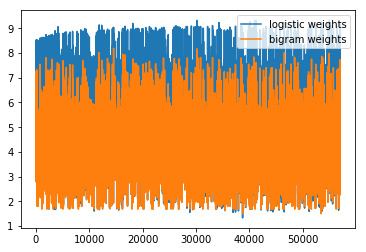

In [139]:
#first plot raw data and see what we get!
plt.plot(losses, label='logistic weights')
plt.plot(bigram_losses, label='bigram weights')
plt.legend()
plt.show()

avg_bigram_loss: 4.50734136604


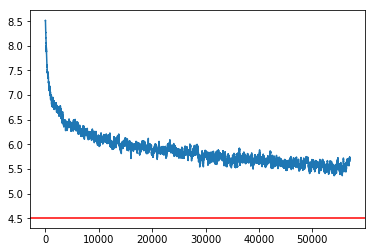

In [140]:
#now plot smoothed data
plt.plot(smoothed_loss(losses))
avg_bigram_loss = np.mean(bigram_losses)
print("avg_bigram_loss:", avg_bigram_loss)
plt.axhline(y=avg_bigram_loss, color='r', linestyle='-')
plt.show()

#plot smoothed losses to reduce variability


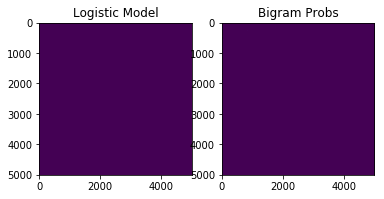

In [141]:
# plot W and bigram probs side-by-side
# for the most common 200 words
plt.subplot(1,2,1)
plt.title("Logistic Model")
plt.imshow(softmax(W))
plt.subplot(1,2,2)
plt.title("Bigram Probs")
plt.imshow(bigram_probs)
plt.show()

# Conclusion

Interesting! So as expected, the logistic model weights converge towards the bigram model weights (log(bigram_probas)). **Neat! So really the linear model is just the roundabout way of getting the bigram counts... At least thats what is seems to be!**